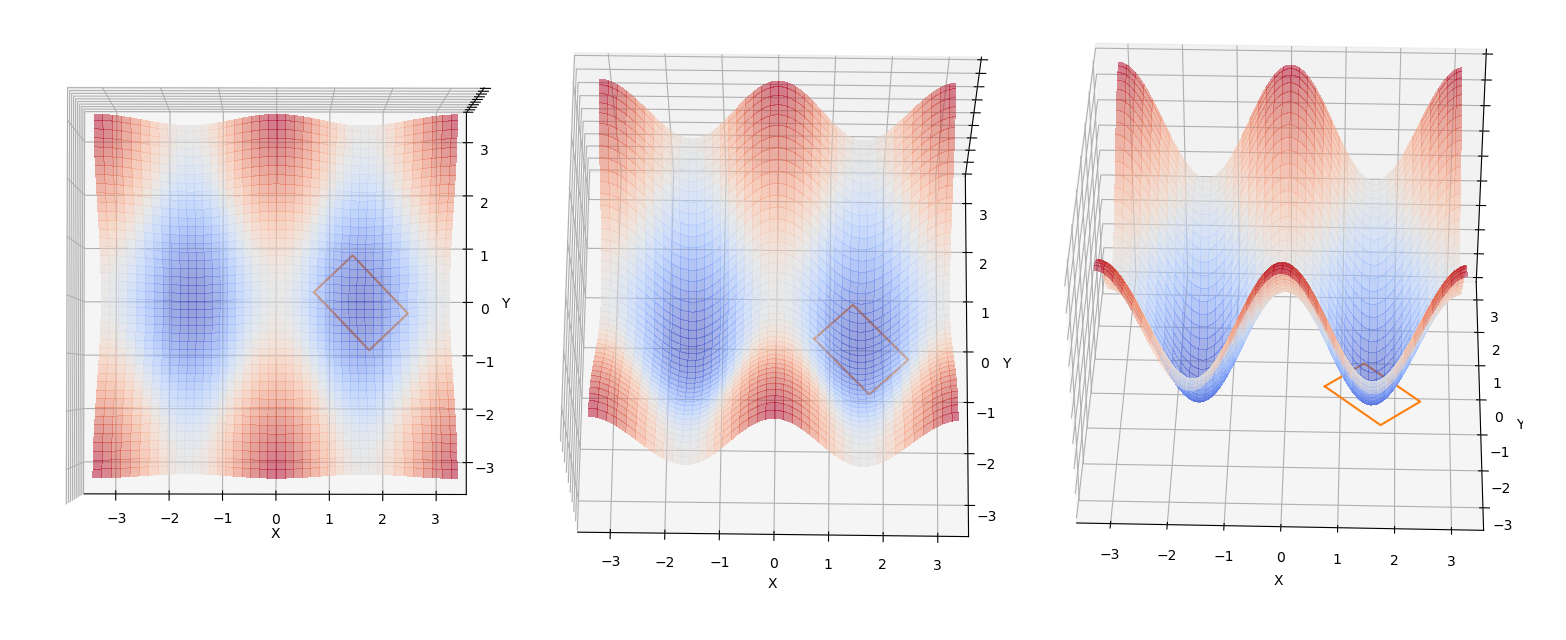

Some time ago, I needed to create some modeling that is hard to do by hand. I ended up using some symbolic packages, some taylor expansions, integrations and then optimization. In my case it was to calculate the best position of a robot given a cost surface.

In the image above, it can be seen (probably most clearly on the left) the position of a rotated rectangle maximizing the blue part of the surface. As you can see more clearly in the subsequent images, the color represents the elevation of the surface, or the cost at any given point. The objective is, given a robot (or a rectangle), determine the position that minimizes the total cost of the area below the robot.

In the case of the image, we are in a local minima, but it's good enough to have one possible result (for our case at least).

## Model

We start simply with a change on coordinate frame. One of our tools is the [Rotation Matrix](https://en.wikipedia.org/wiki/Rotation_matrix).

$$
R(\theta)={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \end{bmatrix}}
$$

This rotation matrix is going to allow the rotation of the local coordinate frame. We can define the transformation of coordinates as follows.

$$
g(x_l,y_l,\hat{x},\hat{y},\hat{\theta})=\begin{bmatrix}
 \bar{x}\\
\bar{y}
\end{bmatrix}=R(\hat{\theta})
\begin{bmatrix} x_l\\y_l\end{bmatrix} +\begin{bmatrix} \hat{x}\\\hat{y}\end{bmatrix}
$$

Where $x_l$ and $y_l$ are the local coordinate system. $\hat{x}$, $\hat{y}$ and $\hat{\theta}$ are the global coordinates of the frame and $\bar{x}$ and $\bar{y}$ is the projection from local to global coordinates. The following picture depicts the variables and the violet star is the point of interest ( $(\bar{x},\bar{y})$ and $(x_l,y_l)$ depending on your reference frame).

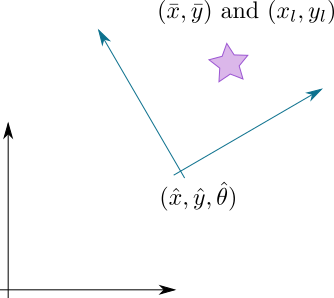



We can extend this transformation and say, well, I can actually integrate from the local coordinates to the global coordinates. In our case, we want to find a predefined area in our local coordinates. Let's say over the interval $x_l\in[0,1.5]$ and $y_l\in[0,1]$ (i.e. $I_{x_l}=[0,1.5]$ and $I_{y_l}=[0,1]$). We can image it as the following picture.

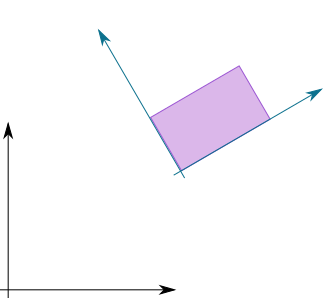

The violet area is our area of interest (the area we want to integrate). Thus, we can act on any function or surface $f(\bar{x},\bar{y})$. We know however that the points $(\bar{x},\bar{y})$ are parameterized from $(x_l,y_l,\hat{x},\hat{y},\hat{\theta})$, and thus we can define a new function from the composition of $f$ and $g$.

$$
\Gamma(x_l,y_l,\hat{x},\hat{y},\hat{\theta}) = f(g(x_l,y_l,\hat{x},\hat{y},\hat{\theta}))
$$

We can then integrate with respect to the local intervals.
$$
\zeta(\hat{x},\hat{y},\hat{\theta})  = \int_{I_{x_l}} \int_{I_{y_l}} \Gamma(x_l,y_l,\hat{x},\hat{y},\hat{\theta}) d y_l d x_l
$$

Thus, the function $\zeta(\hat{x},\hat{y},\hat{\theta})$ is the integral over the violate area of the previous picture.

If we then want to find the position that minimizes the value of the evaluated surface, it suffices to minimize that function.

$$
\text{minimize}\quad \zeta(\hat{x},\hat{y},\hat{\theta})
$$

All is missing is a surface. Let's say we have the following one:

$$
f(\bar{x},\bar{y})= \cos^2(\bar{x})+\sin^2(\bar{\frac{y}{2}})
$$

In a world where nothing is complicated, the equations work smoothly. However, even after hours of computation will not have a result. I ended up using a taylor approximation over $\theta$ on 6 terms (which is the default on [`sympy`](https://www.sympy.org/)). This of course has drawbacks, we know that a taylor approximation with few parameters will work only locally. Let's say we can live with it and just do it.

## Code

Let's translate what we saw to code. Hopefully it's almost self-contained with the comments.
The first block contains what is described in the article. The second and third block are the minimization and plotting.

In [1]:
import sympy as sym
from sympy.abc import x,y
import numpy as np
from sympy.integrals import Integral

o_x, o_y, o_theta =  sym.var("o_x, o_y, o_theta")
# transformation
x_new = x*sym.cos(o_theta)-y*sym.sin(o_theta) + o_x
y_new = x*sym.sin(o_theta)+y*sym.cos(o_theta) + o_y

f_ = sym.cos(x_new)**2+sym.sin(y_new/2)**2 # cost function or surface
f = f_.series(o_theta).removeO() # taylor approximation.
x_limits = [0, 1.5]
y_limits = [0, 1]

# integration w.r.t. local coordinate
r = Integral(Integral(f, (x, x_limits[0], x_limits[1])),
             (y, y_limits[0], y_limits[1]))
r_ = r.doit() # computes the double integral

f_ = sym.lambdify((o_x, o_y, o_theta), r_, modules=['numpy']) # translates to numpy

In [2]:
# minimization
from scipy.optimize import minimize
bounds = [(np.pi, np.pi), (np.pi, np.pi), (-np.pi, np.pi)]
res = minimize(lambda x: f_(x[0], x[1], x[2]),
               [0, 0, 0], options={"disp":False})

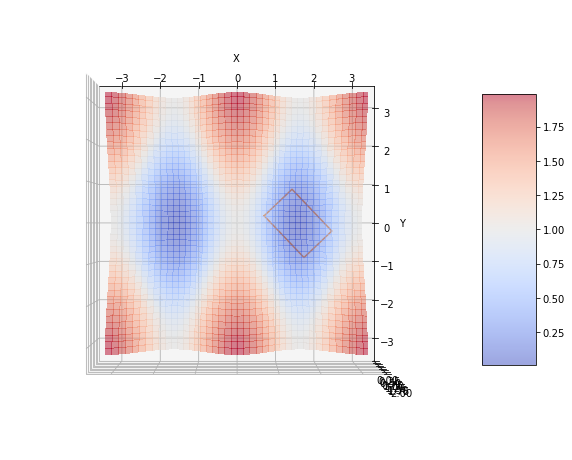

In [3]:
# plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

def new_coords(coors, origin):
    x, y = coors
    o_x, o_y, o_theta = origin
    x_new = x*np.cos(o_theta)-y*np.sin(o_theta) + o_x
    y_new = x*np.sin(o_theta)+y*np.cos(o_theta) + o_y
    return x_new, y_new

# intervals in the global coordinates 
c = []
tmp = new_coords((x_limits[0], y_limits[0]), res.x)
c.append(tmp)
tmp = new_coords((x_limits[0], y_limits[1]), res.x)
c.append(tmp)
tmp = new_coords((x_limits[1], y_limits[1]), res.x)
c.append(tmp)
tmp = new_coords((x_limits[1], y_limits[0]), res.x)
c.append(tmp)
tmp = new_coords((x_limits[0], y_limits[0]), res.x)
c.append(tmp)
c = np.array(c)

plot_x_limits = [-np.pi, np.pi]
plot_y_limits = [-np.pi, np.pi]

# Make data.
X = np.arange(*plot_x_limits, 0.05)
Y = np.arange(*plot_y_limits, 0.05)
X, Y = np.meshgrid(X, Y)
Z = np.cos(X)**2 + np.sin(.5*Y)**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=90., azim=-90)

ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Z')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.plot(c.T[0], c.T[1])

plt.show()

Last but not least. Let's print the value of our approximated $\zeta$ and talk a bit about it.

In [4]:
r_

o_theta**5*(-0.28125*sin(o_x + 1.5)**2 + 0.0625*sin(o_x + 1.5)*cos(o_x + 1.5) + 0.0955078125*sin(o_y/2 + 1/2)**2 - 0.03515625*sin(o_y/2 + 1/2)*cos(o_y/2 + 1/2) + 0.192361111111111*cos(o_x + 1.5)**2 + 0.0703125*cos(o_y/2 + 1/2)**2) - 0.1658203125*o_theta**5*sin(o_y/2)**2 + 4*o_theta**5*cos(o_x)**2/45 + o_theta**4*(-0.09375*sin(o_x + 1.5)**2 - 0.447222222222222*sin(o_x + 1.5)*cos(o_x + 1.5) - 0.015625*sin(o_y/2 + 1/2)**2 - 0.09453125*sin(o_y/2 + 1/2)*cos(o_y/2 + 1/2) + 0.09375*cos(o_x + 1.5)**2 + 0.015625*cos(o_y/2 + 1/2)**2) - 83*o_theta**4*sin(o_x)*cos(o_x)/720 + 0.28203125*o_theta**4*sin(o_y/2)*cos(o_y/2) + o_theta**3*(-0.75*sin(o_x + 1.5)*cos(o_x + 1.5) + 0.1640625*sin(o_y/2 + 1/2)**2 - 0.5625*sin(o_y/2 + 1/2)*cos(o_y/2 + 1/2)) - 0.1640625*o_theta**3*sin(o_y/2)**2 + o_theta**2*(0.375*sin(o_x + 1.5)**2 - 0.0833333333333333*sin(o_x + 1.5)*cos(o_x + 1.5) - 0.375*sin(o_y/2 + 1/2)**2 - 0.1875*sin(o_y/2 + 1/2)*cos(o_y/2 + 1/2) - 0.375*cos(o_x + 1.5)**2 + 0.375*cos(o_y/2 + 1/2)**2) + o_thet

This is the part that we don't want to do (and that I'm probably not able to do). To make this kind of computation by hand will take ages.